https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py

---
## Dependencies and Imports

In [1]:
!pip install gensim

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

# many examples on the 'web use older versions of Gensim, so you may have to
# fix their code before use.
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")


python==3.11.3
pandas==1.5.3
gensim==4.3.0
scikit-learn==1.2.2
matplotlib==3.7.1


In [3]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [4]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus.head()


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])

In [7]:
#"""**Create a model using Doc2Vec and train it**"""

d2v_model = Doc2Vec(all_content, vector_size=300, min_count = 5,dm = 0, 
                alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


In [8]:
len(d2v_model.dv.vectors)

248

In [9]:
type(d2v_model.dv.cosine_similarities)

# read on cosine_similarities

function

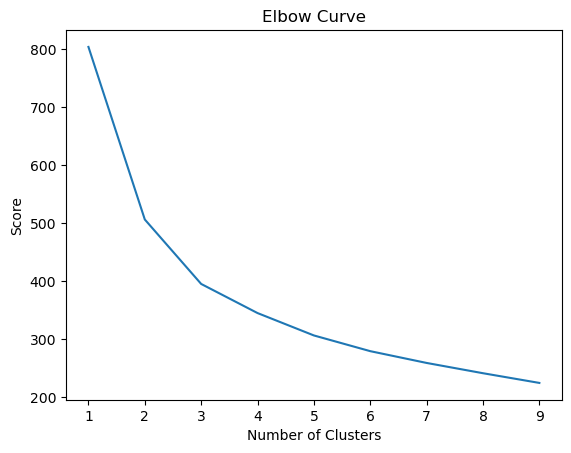

In [10]:
#"""**Apply K-means clustering on the model**"""
#Elbow Method
nc = range(1,10)
kmeans = []
score = []
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [41]:
K_value = 5
# XXX for Gensim 3.8.3, which is no longer installable... kmeans_model = KMeans(n_clusters = K_value, init='k-means++', n_init = 2000, max_iter = 6000, precompute_distances = 'auto')  
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
X = kmeans_model.fit(d2v_model.dv.vectors)
clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


In [42]:
#PCA
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)


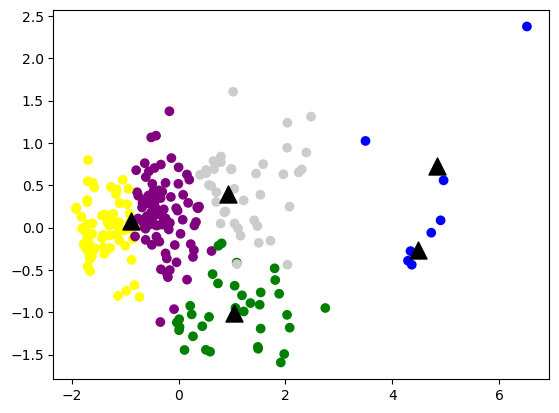

In [43]:
#GRAPH
#"""**Plot the clustering result**"""

plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()


In [25]:
kmeans_clusters = pd.DataFrame(corpus.index)
kmeans_clusters['clusters'] = labels

In [27]:
documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv")
documents['Jaar'] = documents['Jaar'].astype("string").str.slice(0, 4)
gemeenten = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
kmeans_clusters = kmeans_clusters.merge(documents, how="left", left_on=0, right_on='DocID')
kmeans_clusters['GM_Code'] = kmeans_clusters['DocID'].str.slice(0, 6)
kmeans_clusters = kmeans_clusters.merge(gemeenten, how="left", on='GM_Code')

In [33]:
kmeans_clusters.loc[kmeans_clusters['clusters']==4, ['DocID', 'GM_Code', 'Gemeente', 'Titel', 'Jaar']]

,DocID,GM_Code,Gemeente,Titel,Jaar
1,GM0005DV01,GM0005,Bedum,Milieubeleidsplan 2009-2012,2009
2,GM0007DV01,GM0007,Bellingwedde,Milieubeleidsprogramma 2007-2015,2007
15,GM0063DV01,GM0063,het Bildt,Milieubeleidsplan,2015
46,GM0230DV01,GM0230,Elburg,Milieubeleidsplan Gemeente Elburg 2010-2013,2013
53,GM0274DV01,GM0274,Renkum,Milieuvisie 2013-2016,2013
56,GM0281DV01,GM0281,Tiel,Milieuvisie 2010-2020 - Gemeente Tiel,2010
57,GM0293DV01,GM0293,Westervoort,Milieuprogramma Westervoort,2016
58,GM0294DV01,GM0294,Winterswijk,Duurzaam Winterswijk,2008
76,GM0362DV01,GM0362,Amstelveen,Actieplan Luchtkwaliteit Amstelveen 2007-2015,2007
77,GM0362DV02,GM0362,Amstelveen,Nota Duurzaam Bouwen 2007-2012,2007
